### Naive Bayes Model

In this notebook we will use *Naive Bayes* for our classification.
We will be using the *Dry Bean* [dataset from UCI](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset).

In [37]:
## first the imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
## ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

### loading the data

In [3]:
data = pd.read_csv('https://archive.ics.uci.edu/static/public/602/data.csv')
data.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRatio      13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [10]:
def data_cleaner(df):
    df.columns = [x.replace(r'\s+', '_').lower() for x in df.columns]
    type_dict = {}
    for col in df.columns:
        if df[col].dtype == 'float64' and df[col].min() == df.astype({col:'float16'})[col].min():
            type_dict[col] = 'float16'
        elif df[col].dtype == 'float64' and df[col].min() == df.astype({col:'float32'})[col].min():
            type_dict[col] = 'float32'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int16'})[col].min():
            type_dict[col] = 'int16'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int32'})[col].min():
            type_dict[col] = 'int32'
        elif df[col].dtype == 'object' and df[col].nunique() < 5:
            df = pd.get_dummies(data=df, columns=[col])

    return df.astype(type_dict)

cleaned_data = data_cleaner(data.copy())
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             13611 non-null  int32  
 1   perimeter        13611 non-null  float64
 2   majoraxislength  13611 non-null  float64
 3   minoraxislength  13611 non-null  float64
 4   aspectratio      13611 non-null  float64
 5   eccentricity     13611 non-null  float64
 6   convexarea       13611 non-null  int32  
 7   equivdiameter    13611 non-null  float64
 8   extent           13611 non-null  float64
 9   solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  compactness      13611 non-null  float64
 12  shapefactor1     13611 non-null  float64
 13  shapefactor2     13611 non-null  float64
 14  shapefactor3     13611 non-null  float64
 15  shapefactor4     13611 non-null  float64
 16  class            13611 non-null  object 
dtypes: float64(1

### visualizing the distribution for the classes

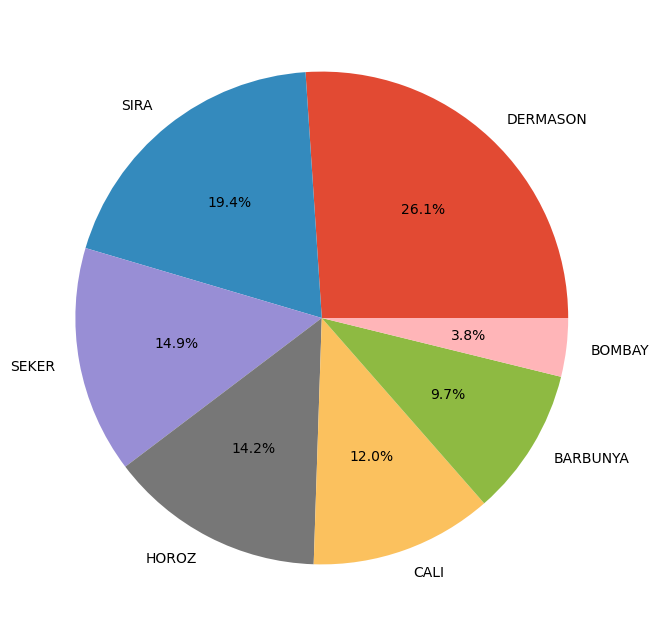

In [38]:
## getting the values for each class
values = cleaned_data['class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(values.values, labels = values.index,
       autopct='%1.1f%%');

Two of the classes seem to be lacking the same number of instances as the rest, we might have to consider that when we're splitting the data.

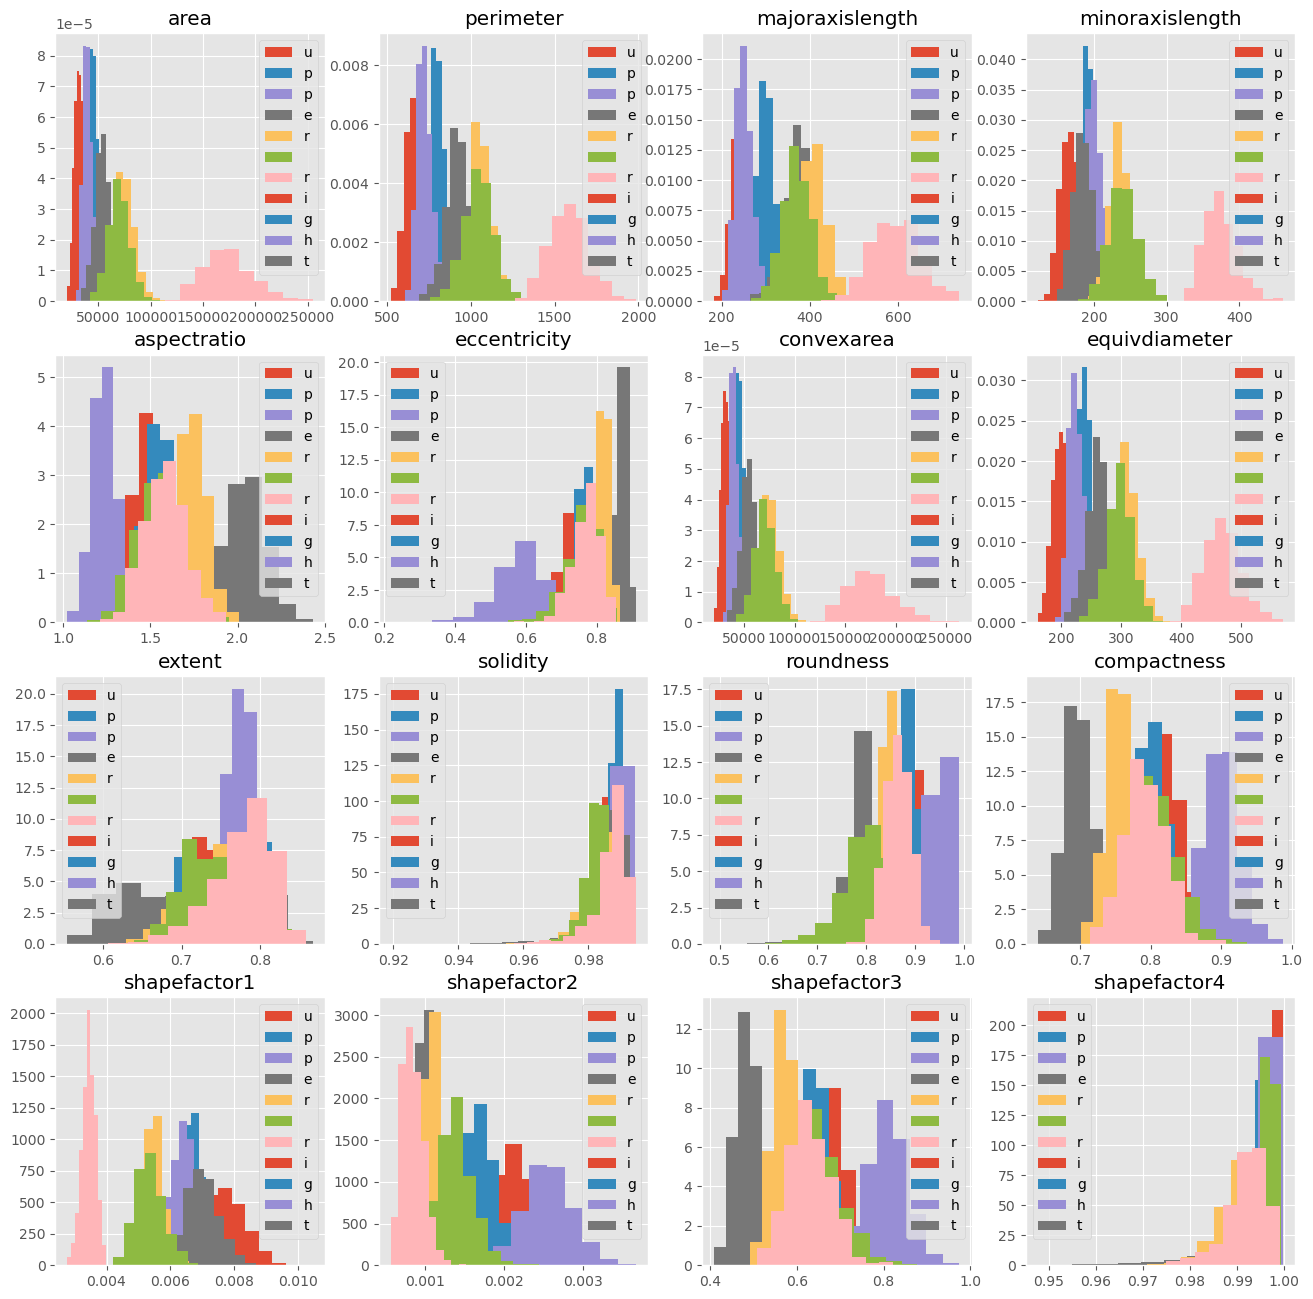

In [48]:
## checking the dist for each variable
nrows, ncols = 4, 4 
plt.figure(figsize = (16, 16))
c = 1
for col in cleaned_data.drop('class', axis=1).columns:
    for type in values.index:
        plt.subplot(nrows, ncols, c)
        plt.hist(cleaned_data[cleaned_data['class'] ==type][col], 
                 density=True, label=type)
        plt.title(col)
        
    c+=1
    plt.legend('upper right');

In [40]:
X, y = cleaned_data.drop('class', axis=1), cleaned_data['class']
X.head()

,area,perimeter,majoraxislength,minoraxislength,aspectratio,eccentricity,convexarea,equivdiameter,extent,solidity,roundness,compactness,shapefactor1,shapefactor2,shapefactor3,shapefactor4
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166


In [41]:
X.shape

(13611, 16)